In [ ]:
!pip install torch transformers datasets gensim scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install transformers[torch] accelerate -U
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 37.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


In [ ]:
import pandas as pd
from datasets import Dataset, load_metric, load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import accelerate
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score
import transformers
from transformers import get_linear_schedule_with_warmup
from google.colab import drive
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import Counter
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, EarlyStoppingCallback
gc.collect()
print(gensim.__version__)
drive.mount('/content/drive')


4.3.2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Preprocess Dataset and Word Embedding

In [ ]:
df_health = pd.read_csv('HealthNews.csv')
df_sport = pd.read_csv('SportNews.csv')

In [ ]:
print(df_health.dtypes)
print(df_sport.dtypes)

content    object
Label       int64
dtype: object
content    object
Label       int64
dtype: object


In [ ]:
print(df_health.isnull().sum())
print(df_sport.isnull().sum())

content    0
Label      0
dtype: int64
content    0
Label      0
dtype: int64


In [ ]:
#Loading word2vec word embedding
word_embeddings = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)

# Get the shape of word embeddings
embedding_dimension = word_embeddings.vectors.shape[1]

print("Word Embedding Dimension:", embedding_dimension)

Word Embedding Dimension: 300


In [ ]:
#Splitting train, test and eval
df_train_health,df_test_health = train_test_split(df_health, test_size=0.2 ,random_state=42)
df_eval_health, df_test_health = train_test_split(df_test_health, test_size = 0.5, random_state=42)

In [ ]:
#Splitting train, test and eval
df_train_sport,df_test_sport = train_test_split(df_sport, test_size=0.2 ,random_state=42)
df_eval_sport, df_test_sport = train_test_split(df_test_sport, test_size = 0.5, random_state=42)

In [ ]:
print(f'Total Train: {len(df_train_health)}')
print(f'Total Val  : {len(df_eval_health)}')
print(f'Total Test : {len(df_test_health)}')

Total Train: 4000
Total Val  : 500
Total Test : 500


In [ ]:
print(f'Total Train: {len(df_train_sport)}')
print(f'Total Val  : {len(df_eval_sport)}')
print(f'Total Test : {len(df_test_sport)}')

Total Train: 4000
Total Val  : 500
Total Test : 500


In [ ]:
#saving each train,test, and eval to csv
df_train_health.to_csv("train_health.csv", index=False)
df_eval_health.to_csv("eval_health.csv", index=False)
df_test_health.to_csv("test_health.csv", index=False)

In [ ]:
#saving each train,test, and eval to csv
df_train_sport.to_csv("train_sport.csv", index=False)
df_eval_sport.to_csv("eval_sport.csv", index=False)
df_test_sport.to_csv("test_sport.csv", index=False)

In [ ]:
#loading CSV for each domain as Dataset type to be used for classification
files_health = {
    "train": "train_health.csv",
    "eval": "eval_health.csv",
    "test": "test_health.csv",
}

dataset_health = load_dataset('csv', data_files=files_health)

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
#loading CSV for each domain as Dataset type to be used for classification
files_sport = {
    "train": "train_sport.csv",
    "eval": "eval_sport.csv",
    "test": "test_sport.csv",
}

dataset_sport = load_dataset('csv', data_files=files_sport)

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

##Implementation

In [ ]:
# Load the accuracy metric
accuracy_metric = load_metric("accuracy")

# Function to compute accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {'accuracy': accuracy['accuracy']}

<ipython-input-18-00724eb61c95>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


In [ ]:
# Initialize BERT tokenizer and model
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
config = AutoConfig.from_pretrained(bert_model_name, num_labels=2)
model = BertForSequenceClassification.from_pretrained(bert_model_name, config=config)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
#Function to use Tokenizer
def tokenizer_transformer(examples):
    encoding = tokenizer(examples["content"], padding='max_length', max_length=256, truncation=True, return_tensors="pt")

    # More debugging: Inspect encoding shapes
    print(f"Input IDs shape: {encoding['input_ids'].shape}")
    print(f"Attention Mask shape: {encoding['attention_mask'].shape}")
    print(f"Token Type IDs shape: {encoding['token_type_ids'].shape}")

    labels = torch.tensor(examples['Label'])
    print(f"Labels shape: {labels.shape}, First label: {labels[0]}")  # Debugging labels

    return {
        'input_ids': encoding['input_ids'],
        'token_type_ids': encoding['token_type_ids'],
        'attention_mask': encoding['attention_mask'],
        'labels': labels
    }

# Apply the transformation to your dataset
tokenized_datasets_health = dataset_health.map(tokenizer_transformer, batched = True)
tokenized_datasets_sport = dataset_sport.map(tokenizer_transformer, batched = True)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Token Type IDs shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 0
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Token Type IDs shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 0
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Token Type IDs shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 1
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Token Type IDs shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 1


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([500, 256])
Attention Mask shape: torch.Size([500, 256])
Token Type IDs shape: torch.Size([500, 256])
Labels shape: torch.Size([500]), First label: 1


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([500, 256])
Attention Mask shape: torch.Size([500, 256])
Token Type IDs shape: torch.Size([500, 256])
Labels shape: torch.Size([500]), First label: 0


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Token Type IDs shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 0
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Token Type IDs shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 1
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Token Type IDs shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 0
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Token Type IDs shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 0


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([500, 256])
Attention Mask shape: torch.Size([500, 256])
Token Type IDs shape: torch.Size([500, 256])
Labels shape: torch.Size([500]), First label: 0


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([500, 256])
Attention Mask shape: torch.Size([500, 256])
Token Type IDs shape: torch.Size([500, 256])
Labels shape: torch.Size([500]), First label: 1


In [ ]:
#Assign each dataset from the tokenized dataset
train_datasets_health = tokenized_datasets_health["train"]
test_datasets_health = tokenized_datasets_health["test"]
eval_datasets_health = tokenized_datasets_health["eval"]

In [ ]:
#Assign each dataset from the tokenized dataset
train_datasets_sport = tokenized_datasets_sport["train"]
test_datasets_sport = tokenized_datasets_sport["test"]
eval_datasets_sport = tokenized_datasets_sport["eval"]

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
if torch.cuda.is_available():
    print("A GPU device is available.")
else:
    print("No GPU device is available. Training will default to CPU.")

A GPU device is available.


In [ ]:
#Create Training Arguments for hyperparameter tuning
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    warmup_ratio=0.1,
    num_train_epochs=5,
    greater_is_better=True,
    metric_for_best_model='accuracy',
    gradient_accumulation_steps=4,
    fp16=True,
    lr_scheduler_type="linear",      # Added learning rate scheduler
    save_total_limit=1,              # Save only the best model
    load_best_model_at_end=True,     # Load the best model at the end of training
)

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#Assign Trainer for Training the model with the dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_datasets_sport,
    eval_dataset=eval_datasets_sport,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],


)
transformers.logging.set_verbosity_info()

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, Label. If content, Label are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4,000
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 1,250
  Number of trainable parameters = 109,483,778


Epoch,Training Loss,Validation Loss,Accuracy
1,0.204300,0.171469,0.944000
2,0.115100,0.151221,0.954000
3,0.003900,0.156147,0.966000
4,0.000500,0.176984,0.966000
5,0.000300,0.223934,0.958000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, Label. If content, Label are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 500
  Batch size = 4
Saving model checkpoint to ./results/checkpoint-250
Configuration saved in ./results/checkpoint-250/config.json
Model weights saved in ./results/checkpoint-250/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, Label. If content, Label are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 500
  Batch size = 4
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights 

TrainOutput(global_step=1250, training_loss=0.07880858860015869, metrics={'train_runtime': 485.7647, 'train_samples_per_second': 41.172, 'train_steps_per_second': 2.573, 'total_flos': 2631110553600000.0, 'train_loss': 0.07880858860015869, 'epoch': 5.0})

In [ ]:
trainer.evaluate(test_datasets_health)

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, Label. If content, Label are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 500
  Batch size = 4


{'eval_loss': 2.12137508392334,
 'eval_accuracy': 0.564,
 'eval_runtime': 3.0242,
 'eval_samples_per_second': 165.331,
 'eval_steps_per_second': 41.333,
 'epoch': 5.0}

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, Label. If content, Label are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 500
  Batch size = 4


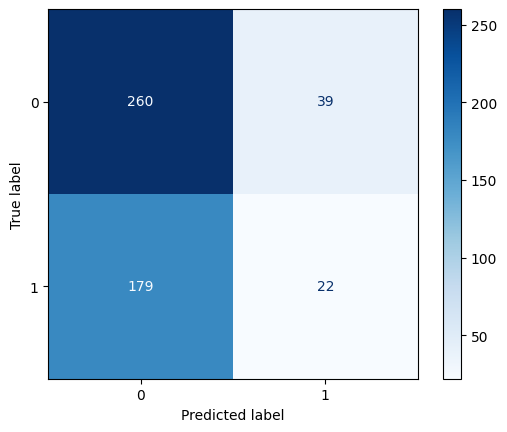

In [ ]:
#Creating Confusion Matrix

import matplotlib.pyplot as plt
# Make predictions on the evaluation dataset
predictions, label_ids, metrics = trainer.predict(test_datasets_health)

# Convert raw logits to predicted labels
predicted_labels = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(label_ids, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()



In [ ]:
# Print the classification report
report = classification_report(label_ids, predicted_labels, target_names=["Fake News", "Not Fake News"])
print("Classification Report:\n", report)

# Print the metrics
print(metrics)

Classification Report:
                precision    recall  f1-score   support

    Fake News       0.59      0.87      0.70       299
Not Fake News       0.36      0.11      0.17       201

     accuracy                           0.56       500
    macro avg       0.48      0.49      0.44       500
 weighted avg       0.50      0.56      0.49       500

{'test_loss': 2.12137508392334, 'test_accuracy': 0.564, 'test_runtime': 3.0314, 'test_samples_per_second': 164.938, 'test_steps_per_second': 41.235}


In [ ]:
#Assign Trainer to train model with another domain dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_datasets_health,
    eval_dataset=eval_datasets_health,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)


Using auto half precision backend


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, Label. If content, Label are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4,000
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 1,250
  Number of trainable parameters = 109,483,778


Epoch,Training Loss,Validation Loss,Accuracy
1,0.039200,0.042532,0.994000
2,0.061300,0.049186,0.994000
3,0.000100,0.043409,0.996000
4,0.000000,0.060786,0.992000
5,0.000000,0.065571,0.992000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, Label. If content, Label are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 500
  Batch size = 4
Saving model checkpoint to ./results/checkpoint-250
Configuration saved in ./results/checkpoint-250/config.json
Model weights saved in ./results/checkpoint-250/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, Label. If content, Label are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 500
  Batch size = 4
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights 

TrainOutput(global_step=1250, training_loss=0.05449114705324173, metrics={'train_runtime': 499.0726, 'train_samples_per_second': 40.074, 'train_steps_per_second': 2.505, 'total_flos': 2631110553600000.0, 'train_loss': 0.05449114705324173, 'epoch': 5.0})

In [ ]:
trainer.evaluate(test_datasets_health)

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, Label. If content, Label are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 500
  Batch size = 4


{'eval_loss': 0.051786284893751144,
 'eval_accuracy': 0.992,
 'eval_runtime': 2.5162,
 'eval_samples_per_second': 198.71,
 'eval_steps_per_second': 49.678,
 'epoch': 5.0}

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: content, Label. If content, Label are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 500
  Batch size = 4


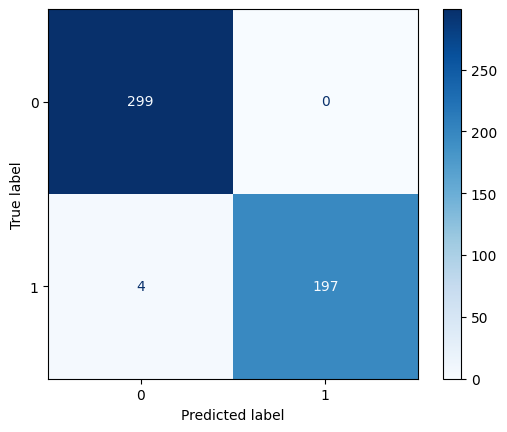

In [ ]:
#Create Confusion Matrix

import matplotlib.pyplot as plt
# Make predictions on the evaluation dataset
predictions, label_ids, metrics = trainer.predict(test_datasets_health)

# Convert raw logits to predicted labels
predicted_labels = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(label_ids, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()



In [ ]:
# Print the classification report
report = classification_report(label_ids, predicted_labels, target_names=["Fake News", "Not Fake News"])
print("Classification Report:\n", report)

# Print the metrics
print(metrics)

Classification Report:
                precision    recall  f1-score   support

    Fake News       0.99      1.00      0.99       299
Not Fake News       1.00      0.98      0.99       201

     accuracy                           0.99       500
    macro avg       0.99      0.99      0.99       500
 weighted avg       0.99      0.99      0.99       500

{'test_loss': 0.051786284893751144, 'test_accuracy': 0.992, 'test_runtime': 2.6161, 'test_samples_per_second': 191.124, 'test_steps_per_second': 47.781}
